# Section 03: Analyzing Microbial Communities

- Author: Qiyun Zhu

A microbiome is a [**community**](https://en.wikipedia.org/wiki/Community_(ecology)) -- a group of microorganisms cohabitating the same environment, such as the gut of a human subject or the soil around a plant's root. These microbes usually interact with each other and with the environment (host or natural). The field of **community ecology** studies the distribution and relationships of community members. Modern microbiome research has adopted many notions and approaches from community ecology, as they are effective tools for decoding microbiomes and their roles in the biological system.

The most familiar ecological term to a microbiome researcher may be [**diversity**](https://en.wikipedia.org/wiki/Biodiversity). While this term is intuitive, its underlying nature is tricky and much discussed. In the very basic sense, community diversity can be divided into:

- [**Alpha diversity**](https://en.wikipedia.org/wiki/Alpha_diversity): The diversity within an community.
- [**Beta diversity**](https://en.wikipedia.org/wiki/Beta_diversity): The diversity between two communities.

scikit-bio implements a large variety of community diversity metrics, and efficient algorithms for pre-processing community data, calculating diversity, and subsequent analyses of diversity measurements. This section will focus on understanding, calculating and utilizing alpha diversity in microbiome research.

## Preparation

Install the latest version of scikit-bio if it hasn't been (needed for every Google Colab instance).

In [1]:
from importlib.util import find_spec

In [2]:
if find_spec('skbio') is None:
    !pip install -q scikit-bio

In [3]:
import skbio
skbio.__version__

'0.7.2'

Download the EMP500 dataset and unzip it. (If you have done it already, skip the following code.)

In [4]:
!wget -q -O emp500.tar.gz "https://www.dropbox.com/scl/fi/7sepykr3vhss60647osc8/emp500.tar.gz?rlkey=6q5ac48noeax5n2htaqslvo8g&dl=0"
!tar zxf emp500.tar.gz

In [5]:
HOME = 'emp500'

Check if the directory exists by listing its content.

In [6]:
!ls $HOME

README.md  amplicon  assembly  masspec	sample.tsv  shotgun


Import common libraries.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Community data

We will use the EMP500 dataset to demonstrate alpha diversity calculation and analysis.

As discussed in section 03, the EMP500 dataset consists of multiple omic data types. We will use the operational genomic unit (OGU) table derived from shotgun metagenomic data as the starting point. The following code for reading and previewing the OGU table was adopted from section 03.

In [8]:
from skbio import Table

In [9]:
table = Table.read(f'{HOME}/shotgun/ogu.biom')
table

14933 x 801 <class 'biom.table.Table'> with 1344863 nonzero entries (11% dense)

In [10]:
table.to_dataframe().head()

,13114.angenent.65.s001,13114.angenent.65.s002,13114.angenent.65.s003,13114.angenent.65.s004,13114.angenent.65.s005,13114.angenent.65.s006,13114.angenent.65.s007,13114.angenent.65.s008,13114.angenent.65.s009,13114.berry.2.s001,...,13114.zaneveld.9.s013,13114.zaneveld.9.s014,13114.zaneveld.9.s015,13114.zaneveld.9.s016,13114.zaneveld.9.s017,13114.zaneveld.9.s018,13114.zaneveld.9.s019,13114.zaneveld.9.s020,13114.zaneveld.9.s021,13114.zaneveld.9.s022
G000005825,120.0,NaN,NaN,NaN,51.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G000006175,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G000006605,1.0,4.0,NaN,1.0,2.0,NaN,1.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G000006725,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G000006745,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,18.0,NaN,NaN,NaN,1.0,2.0


This data table is also referred to as a [contingency table](https://en.wikipedia.org/wiki/Contingency_table), in which cell values represent the frequencies (counts) of individual variables (OGUs, ASVs, etc.). Therefore, they must be **non-negative integers**. This is a pre-requisite for community diversity analysis in its orthodox form. Although some diversity metrics actually support floating-point numbers (e.g., normalized gene expression data in the unit of TPM), they still have to be non-negative.

In community ecology, each variable is usually referred to as a **species**. However, this "species" may or may not be strictly the taxonomic rank [species](https://en.wikipedia.org/wiki/Species). In fact, any groups of organisms (or other biological entities) at a certain rank can be the target of the study. scikit-bio uses the term [**taxon**](https://en.wikipedia.org/wiki/Taxon) (plural: **taxa**) for generalization purpose (see here an [explanation](https://scikit.bio/docs/latest/diversity.html#introduction)).

## Taxon count

As discussed in section 03, this contingency table (as well as other omic data tables) is [sparse](https://en.wikipedia.org/wiki/Sparse_matrix). Only 11% of the cells have non-negative values. That is, each sample only contains a small subset of the microorganisms discovered across the study.

In [11]:
table.get_table_density()

0.11243420779272678

We can count the number of taxa (OGUs) per sample. In the following code, [`pa`](https://scikit.bio/docs/latest/generated/skbio.table.Table.pa.html) converts counts into presence/absence (i.e., positive numbers become 1, zeros remain 0), and [`sum`](https://scikit.bio/docs/latest/generated/skbio.table.Table.sum.html) sums up the data per sample.

In [12]:
sums = table.pa(inplace=False).sum('sample')
sums[:10]

array([3365., 3541., 1007., 1963., 2511., 1231., 2741., 1259., 2098.,
       2450.])

This simple calculation is equivalent to the most essential alpha diversity metric: [**observed species richness**](https://en.wikipedia.org/wiki/Species_richness#Trends_in_species_richness) ($S_{obs}$, or simply $S$). It is also know as "observed features" or "observed OTUs" in the current and former versions of QIIME 2.

As revealed by this result, the 801 samples of the EMP500 study have 1679 ± 1242 taxa.

In [13]:
sums.mean(), sums.std(ddof=1)

(np.float64(1678.980024968789), np.float64(1242.4955772961528))

An important note about read-based shotgun metagenomics (introduced in section 03) is that it is prone to false assignments, due to the similarity among reference genomes among other reasons. As a consequence, the contingency table may be inflated with low-abundance false-positive taxa ([Simon et al., 2019](https://www.cell.com/cell/fulltext/S0092-8674(19)30775-5)). There are bioinformatic methods specifically designed to mitigate false positives. Meanwhile, it is important to understand the limitations of specific data types and analyses.

## Alpha diversity

scikit-bio has a built-in function to calculate $S_{obs}$: [`sobs`](https://scikit.bio/docs/latest/generated/skbio.diversity.alpha.sobs.html).

In [14]:
from skbio.diversity.alpha import sobs

Let's calculate $S_{obs}$ for the first sample in the table. It is a bioreactor sludge sample collected in New York, USA.

In [15]:
counts = table.data('13114.angenent.65.s001')
counts

array([120.,   0.,   1., ...,   0.,   0.,   0.], shape=(14933,))

In [16]:
sobs(counts)

3365

A large number of alpha diversity metrics are provided by the [`skbio.diversity.alpha`](https://scikit.bio/docs/latest/generated/skbio.diversity.alpha.html) module. You can read a list of them, their descriptions, and categories at:

- https://scikit.bio/docs/latest/generated/skbio.diversity.alpha.html

Alternatively, one can programmatically print a list of available metrics using:

In [17]:
from skbio.diversity import get_alpha_diversity_metrics

In [18]:
print(get_alpha_diversity_metrics())

['ace', 'berger_parker_d', 'brillouin_d', 'chao1', 'chao1_ci', 'dominance', 'doubles', 'enspie', 'esty_ci', 'faith_pd', 'fisher_alpha', 'gini_index', 'goods_coverage', 'heip_e', 'hill', 'inv_simpson', 'kempton_taylor_q', 'lladser_ci', 'lladser_pe', 'margalef', 'mcintosh_d', 'mcintosh_e', 'menhinick', 'michaelis_menten_fit', 'observed_features', 'observed_otus', 'osd', 'phydiv', 'pielou_e', 'register_aliases', 'renyi', 'robbins', 'shannon', 'simpson', 'simpson_d', 'simpson_e', 'singles', 'sobs', 'strong', 'tsallis']


Each of these metrics is a function that takes a counts vector (i.e., a vector of non-negative integers) as input, and returns a single value.

scikit-bio provides a "driver function": [`alpha_diversity`](https://scikit.bio/docs/latest/generated/skbio.diversity.alpha_diversity.html) to conveniently calculate a certain alpha diversity metric for all samples in the table. The output is a Pandas series.

In [19]:
from skbio.diversity import alpha_diversity

In [20]:
res = alpha_diversity('sobs', table)
res

13114.angenent.65.s001    3365
13114.angenent.65.s002    3541
13114.angenent.65.s003    1007
13114.angenent.65.s004    1963
13114.angenent.65.s005    2511
                          ... 
13114.zaneveld.9.s018      182
13114.zaneveld.9.s019      210
13114.zaneveld.9.s020      207
13114.zaneveld.9.s021     2575
13114.zaneveld.9.s022     2483
Length: 801, dtype: int64

The input for `alpha_diversity` can also be a Pandas dataframe or a 2D NumPy array. But note: Samples need to be rows and features (taxa) columns.

In [21]:
alpha_diversity('sobs', table.to_dataframe().T).head(3)

13114.angenent.65.s001    14933
13114.angenent.65.s002    14933
13114.angenent.65.s003    14933
dtype: int64

In [22]:
alpha_diversity('sobs', table.matrix_data.toarray().T).head(3)

0    3365
1    3541
2    1007
dtype: int64

## Sampling depth

Let's plot out the distribution of # observed taxa per sample in a histogram.

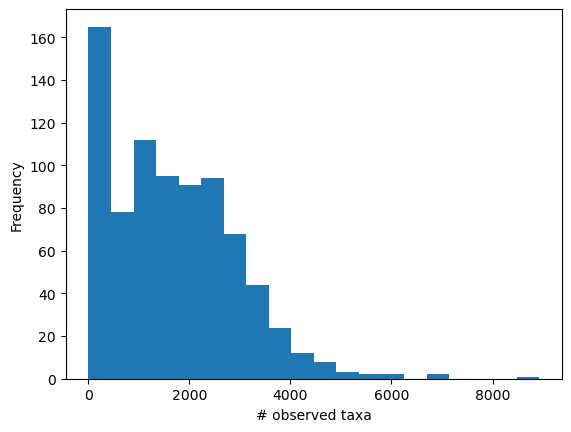

In [23]:
plt.figure()
plt.hist(res, bins=20)
plt.xlabel('# observed taxa')
plt.ylabel('Frequency');

And calculate the descriptive statistics of the distribution.

In [24]:
from scipy.stats import describe

In [25]:
describe(res)

DescribeResult(nobs=np.int64(801), minmax=(np.int64(1), np.int64(8927)), mean=np.float64(1678.980024968789), variance=np.float64(1543795.2596004994), skewness=np.float64(0.861677937132835), kurtosis=np.float64(1.4933626961082087))

As shown, the observed taxon counts vary greatly across samples, from single digits to nearly 9,000.

You may think that biodiversity naturally varies among different environments. However, a technical factor also significantly impacts the calculated alpha diversity: [**sampling depth**](https://www.metagenomics.wiki/pdf/qc/sequencing-depth).

Sampling depth is the amount of data collected for each research target. In traditional ecological research, the target is a community and the sampling depth is the number of organisms one sampled from the environment they habitate. In DNA sequencing-based microbiome research, the target is a biological sample (don't confuse this "sample" with the next one!) and sampling depth is the number of sequencing reads one obtained from it. Therefore it is also known as **sequencing depth**.

- In this shotgun metagenomics-derived contingency table, the sum of taxon counts per sample is the sampling depth. This number is equivalent to the number of sequencing reads that were mapped to reference microbial genomes, excluding low-quality ones and putative contaminations. In other words, it is the number of sequencing reads that consitute the observed community composition in the study.

Why does sampling depth matter? That's because it heavily influences the number of taxa one may observe. The higher the sampling depth, the more likely you will observe a larger number of taxa. The following plot demonstrates this correlation.

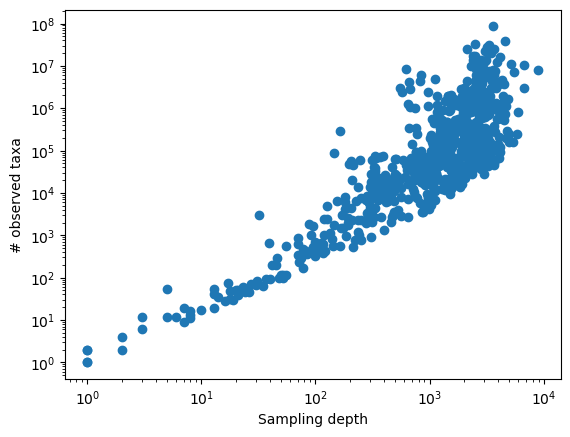

In [26]:
plt.figure()
plt.scatter(res, table.sum('sample'))
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Sampling depth')
plt.ylabel('# observed taxa');

Therefore, to ensure fair comparison, we need to make sampling depth consistent across samples. While we cannot precisely control how many sequencing reads per sample are generated from a sequencing platform, we can perform **subsampling** (a.k.a., [downsampling](https://en.wikipedia.org/wiki/Downsampling_(signal_processing))) to bring down the sum of taxon counts per sample to a constant number.

scikit-bio's [`subsample_counts`](https://scikit.bio/docs/latest/generated/skbio.stats.subsample_counts.html) function can perform subsampling of taxon counts. This function was recently optimized such that its efficiency significantly increased.

In [27]:
from skbio.stats import subsample_counts

Let's subsample the first sample to a sampling depth of 100k.

In [28]:
counts = table.data('13114.angenent.65.s001')
counts

array([120.,   0.,   1., ...,   0.,   0.,   0.], shape=(14933,))

In [29]:
counts.sum()

np.float64(5692931.0)

In [30]:
counts_sub = subsample_counts(counts, 100000)
counts_sub

array([1, 0, 0, ..., 0, 0, 0], shape=(14933,))

In [31]:
counts_sub.sum()

np.int64(100000)

The distribution of taxon counts are largely consistent before and after subsampling.

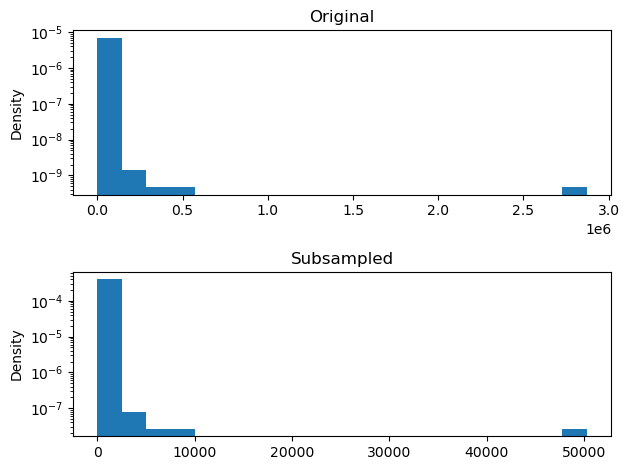

In [32]:
plt.subplot(2, 1, 1)
plt.hist(counts, bins=20, density=True, log=True)
plt.ylabel('Density')
plt.title('Original')
plt.subplot(2, 1, 2)
plt.hist(counts_sub, bins=20, density=True, log=True)
plt.ylabel('Density')
plt.title('Subsampled')
plt.tight_layout()

Note: Subsampling is a stochastic process. The result will be slightly different each time you run it. If reproducibility is desired, you may specify a [random seed](https://en.wikipedia.org/wiki/Random_seed).

In [33]:
counts_sub_1 = subsample_counts(counts, 100000, seed=42)
counts_sub_2 = subsample_counts(counts, 100000, seed=42)
np.array_equal(counts_sub_1, counts_sub_2)

True

Now, we will apply subsampling to all samples in the contingency table to bring them down to a **uniform sampling depth**.

As you can imagine, this sampling depth must be sufficiently large, such that adequate taxa can be represented per sample. This will inevitably drop out samples that are already below this sampling depth from the study. How large a sufficient sampling depth is will be discussed in the "Rarefaction" section below. For now, let's use an arbitrary sampling depth of 100k.

In [34]:
depth = 100000

The [`subsample`](https://scikit.bio/docs/latest/generated/skbio.table.Table.subsample.html) method is a convenient shortcut that:

1. Drop out samples that are below the depth threshold.
2. Perform counts subsampling on all remaining samples to bring them down to the depth threshold.
3. Remove features (taxa) that are zero in all samples after subsampling.

In [35]:
table_sub = table.subsample(depth, seed=42)
table_sub

13892 x 375 <class 'biom.table.Table'> with 556171 nonzero entries (10% dense)

Now, we are ready to perform alpha diversity calculation.

In [36]:
adiv_sobs = alpha_diversity('sobs', table_sub)
adiv_sobs

13114.angenent.65.s001     972
13114.angenent.65.s002    1072
13114.angenent.65.s003     854
13114.angenent.65.s004    1347
13114.angenent.65.s005    1215
                          ... 
13114.tucker.58.s015      1153
13114.tucker.58.s016       847
13114.zaneveld.9.s015      902
13114.zaneveld.9.s021      913
13114.zaneveld.9.s022      961
Length: 375, dtype: int64

## Statistical analysis

The calculated alpha diversity values allow us to compare between samples and sample groups and answer biological questions. To enable this analysis, we will need the sample metadata (detailed in section 03).

Just as a reminder, the EMP500 dataset consists of microbiomes collected from various environments.

In [37]:
from skbio.metadata import SampleMetadata

In [38]:
meta = SampleMetadata.load(f'{HOME}/sample.tsv', default_missing_scheme='INSDC:missing')

The EMP ontology (EMPO) fields define the types of environments where samples were collected.

In [39]:
empo_1 = meta.get_column('empo_1').to_series()
empo_1.value_counts()

empo_1
Free-living        452
Host-associated    428
Name: count, dtype: int64

In [40]:
empo_2 = meta.get_column('empo_2').to_series()
empo_2.value_counts()

empo_2
Non-saline    343
Animal        301
Plant         115
Saline        109
Fungus         12
Name: count, dtype: int64

We can combine the EMPO fields with the calculated alpha diversity values into one dataframe.

In [41]:
df = pd.concat([empo_1, empo_2, adiv_sobs.rename('sobs')], join='inner', axis=1)
df

,empo_1,empo_2,sobs
13114.angenent.65.s001,Host-associated,Animal,972
13114.angenent.65.s002,Host-associated,Animal,1072
13114.angenent.65.s003,Host-associated,Animal,854
13114.angenent.65.s004,Host-associated,Animal,1347
13114.angenent.65.s005,Host-associated,Animal,1215
...,...,...,...
13114.tucker.58.s015,Free-living,Non-saline,1153
13114.tucker.58.s016,Free-living,Non-saline,847
13114.zaneveld.9.s015,Host-associated,Animal,902
13114.zaneveld.9.s021,Free-living,Saline,913


Group $S_{obs}$ values by EMPO1 (host-associated vs. free-living).

In [42]:
grouped = df.groupby('empo_1')['sobs'].apply(np.array)
grouped

empo_1
Free-living        [755, 2492, 3308, 1573, 2975, 1967, 1937, 1633...
Host-associated    [972, 1072, 854, 1347, 1215, 913, 1468, 1041, ...
Name: sobs, dtype: object

Generate a boxplot.

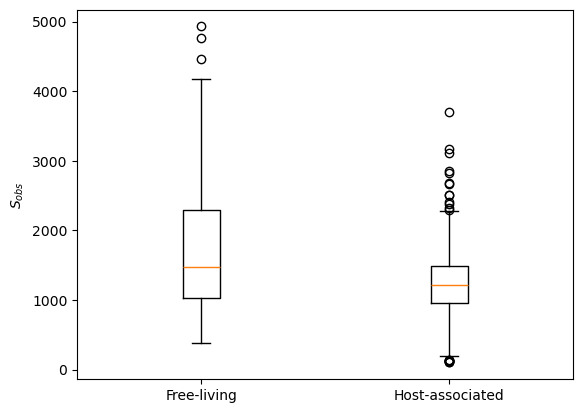

In [43]:
plt.figure()
plt.boxplot(grouped, tick_labels=grouped.index)
plt.ylabel('$S_{obs}$');

It appears from the plot that free-living microbiomes have higher alpha diversity than host-associated ones. We want to confirm this by performing a statistical test.

In microbiome research, because data are usually highly skewed, non-parametric statistical tests (i.e., those that don't assume a normal distribution of data) are favored. They include [Mann-Whitney _U_ test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) (a.k.a., Wilcoxon rank-sum test) for two groups, and [Kruskal-Wallis _H_ test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance) for two or more groups.

In [44]:
from scipy.stats import mannwhitneyu

In [45]:
mannwhitneyu(*grouped)

MannwhitneyuResult(statistic=np.float64(21911.5), pvalue=np.float64(2.9580742771634422e-05))

The *p*-value is between 0.001 and 0.0001 (i.e., three asterisks). Therefore, we can conclude that free-living microbiomes have significantly higher alpha diversity than host-associated microbiomes.

## Rarefaction

The above conclusion is based on a uniform sampling depth of 100k among all samples. However, you may wonder: is this value sufficient for estimating the actual number of taxa within each sample (environment)? How do we know if we have missed out some taxa during this process?

[**Rarefaction**](https://en.wikipedia.org/wiki/Rarefaction_(ecology)) is the technique to address this question. It performs subsampling at a gradient of depths, and plots the alpha diversity calculated from each subsample over sample depth (called a **rarefaction curve**), and lets the researcher examine whether sampling is sufficient.

Let's use the first sample to demonstrate this process.

In [46]:
counts = table.data('13114.angenent.65.s001')
counts

array([120.,   0.,   1., ...,   0.,   0.,   0.], shape=(14933,))

This sample consists of ~5.7M mapped sequencing reads.

In [47]:
counts.sum()

np.float64(5692931.0)

Define a gradient of sampling depths.

In [48]:
depths = np.arange(500000, 6000000, 500000)
depths

array([ 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000,
       4000000, 4500000, 5000000, 5500000])

Perform 10 replicates of random sampling at each depth.

In [49]:
n_reps = 10

In [50]:
res = np.array([[sobs(subsample_counts(counts, n)) for _ in range(n_reps)] for n in depths])
res

array([[1711, 1754, 1723, 1700, 1738, 1750, 1706, 1746, 1716, 1727],
       [2182, 2152, 2198, 2183, 2187, 2171, 2169, 2142, 2163, 2193],
       [2445, 2474, 2476, 2451, 2478, 2443, 2458, 2470, 2474, 2452],
       [2657, 2652, 2687, 2676, 2665, 2684, 2635, 2644, 2656, 2682],
       [2830, 2828, 2835, 2791, 2800, 2826, 2845, 2880, 2840, 2814],
       [2964, 2959, 2969, 2971, 2948, 2948, 2928, 2965, 2936, 2931],
       [3073, 3073, 3036, 3080, 3080, 3067, 3057, 3067, 3072, 3072],
       [3158, 3158, 3152, 3139, 3150, 3147, 3173, 3152, 3144, 3144],
       [3233, 3237, 3219, 3231, 3211, 3227, 3243, 3221, 3229, 3223],
       [3287, 3290, 3281, 3292, 3305, 3296, 3291, 3286, 3282, 3301],
       [3353, 3343, 3351, 3345, 3351, 3344, 3343, 3344, 3343, 3344]])

Calculate the means and standard deviations of $S_{obs}$ values.

In [51]:
means, stds = res.mean(axis=1), res.std(axis=1, ddof=1)
means, stds

(array([1727.1, 2174. , 2462.1, 2663.8, 2828.9, 2951.9, 3067.7, 3151.7,
        3227.4, 3291.1, 3346.1]),
 array([19.15695406, 17.9938261 , 13.70685149, 17.93692653, 24.79896951,
        16.04472914, 12.97904294,  9.64998561,  9.32380466,  7.78103107,
         3.92852814]))

Plot the $S_{obs}$ values over sampling depths. This is the rarefaction curve.

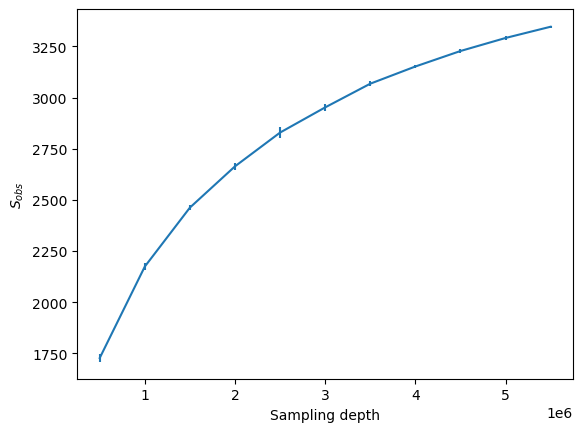

In [52]:
plt.figure()
plt.errorbar(depths, means, stds)
plt.xlabel('Sampling depth')
plt.ylabel('$S_{obs}$');

As we can see, the observed species richness ($S_{obs}$) increases as the sampling depth increases. It grows more slowly as the sampling depth gets larger, suggesting that it will eventually reach a plateau.

However, even at the maximum sampling depth (5.5M), it has not reached the plateau. This suggests that if we were able to further increase sequencing depth (a hypothetical situation), we would expect to find more taxa in this sample. Apparently, this is a hypothetical scenario, because we only have 5.7M (mapped) sequencing reads available.

Let's wrap the code in a custom function such that it can be reused.

In [53]:
def rarefy(counts, metric, depths, n_reps):
    res = np.array([[metric(subsample_counts(counts, n)) for _ in range(n_reps)] for n in depths])
    return res.mean(axis=1), res.std(axis=1, ddof=1)

## Richness

It is usually infeasible to exhaustively collect every organism in an environment. Likewise, it is usually infeasible to sequence every microbe in a biological sample. Given this limitation, can we still somehow estimate the true number of taxa in a sample given the (limited) data?

Various [**species richness**](https://en.wikipedia.org/wiki/Species_richness) metrics have been developed by ecologists to address this challenge. scikit-bio implements a [list of them](https://scikit.bio/docs/latest/generated/skbio.diversity.alpha.html#richness-metrics).

For example, **Chao1 index** is a widely used species richness metric. It assumes that taxon abundances within a sample follow a Poisson distribution, and attempts to correct the observed richness based on the numbers of rare taxa: singletons ($n_1$) and doubletons ($n_2$) (taxa that occur only once and twice in a sample).

$$ chao1=S_{obs} + \frac{n_1(n_1-1)}{2(n_2+1)} $$

In [54]:
from skbio.diversity.alpha import chao1

In [55]:
chao1(counts)

np.float64(3659.306)

Draw a rarefaction curve. You can see that the Chao1 index almost reaches a plateau at large sampling depths.

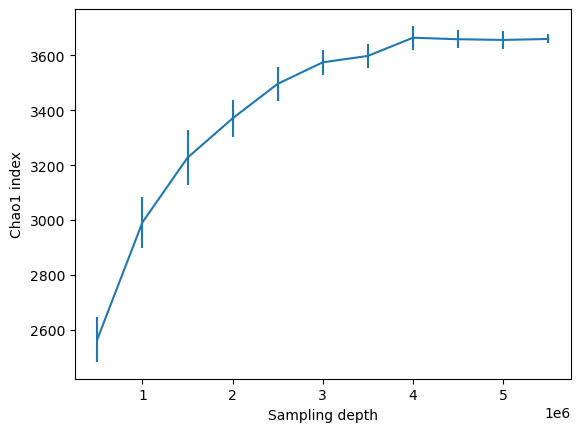

In [56]:
plt.figure()
plt.errorbar(depths, *rarefy(counts, chao1, depths, n_reps))
plt.xlabel('Sampling depth')
plt.ylabel('Chao1 index');

Calculate Chao1 index for all samples after subsampling, and append to the result dataframe.

In [57]:
df['chao1'] = alpha_diversity('chao1', table_sub)

Be careful however, that some omic data processing workflows filter out rare taxa, and Chao1 index may not work as anticipated in these cases.

## Diversity

When we talk about the "diversity" of a community, we not only want to know the number of taxa, but also want to compare their abundances.

For example, let's imagine a healthy gut in which many commensal bacterial species are flourishing, as versus a sick gut in which one pathogenic species dominates the flora, whereas all other species are suppressed to very low abundances. Even they have the same number of taxa, we would think that the former community has higher diversity.

The category of alpha diversity metrics that concerns both information are specifically referred to as [**species diversity**](https://en.wikipedia.org/wiki/Species_diversity) metrics. Their calculations are usually based on the [relative abundance](https://en.wikipedia.org/wiki/Relative_species_abundance) of taxa (i.e., the fraction of the community occupied by each taxon). scikit-bio implements multiple diversity metrics ([list](https://scikit.bio/docs/latest/generated/skbio.diversity.alpha.html#diversity-metrics)).

[**Shannon index**](https://en.wikipedia.org/wiki/Diversity_index#Shannon_index) (a.k.a., Shannon-Wiener index) is among of the most commonly used diversity metrics. It is equivalent to [entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)) in information theory.

$$ H' = -\sum p\log(p) $$

In which $p$ is the relative abundance of each taxon.

In [58]:
from skbio.diversity.alpha import shannon

In [59]:
shannon(counts)

np.float64(2.5260957786362668)

Because its calculation is based on relative abundances, rarefaction has almost no impact on Shannon index (note the scale of the *y*-axis).

This also indicates that even with a very shallow sequencing depth ([Hillmann et al., 2018](https://journals.asm.org/doi/full/10.1128/msystems.00069-18)), one can confidently estimate the Shannon index of the sample.

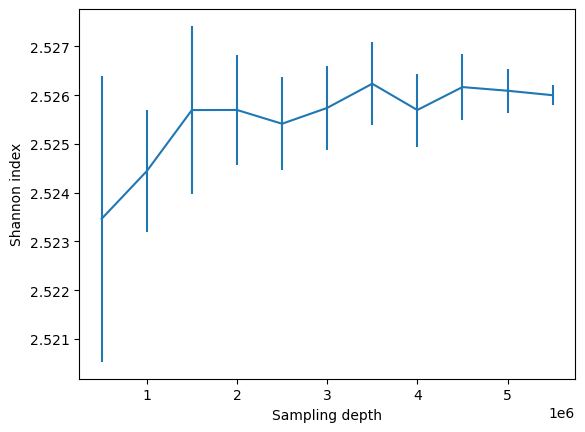

In [60]:
plt.figure()
plt.errorbar(depths, *rarefy(counts, shannon, depths, n_reps))
plt.xlabel('Sampling depth')
plt.ylabel('Shannon index');

In [61]:
df['shannon'] = alpha_diversity('shannon', table_sub)

**Simpson's diversity index** (a.k.a., [Gini-Simpson index](https://en.wikipedia.org/wiki/Diversity_index#Gini%E2%80%93Simpson_index)) (but don't call it Simpson index, which is ambiguous) is another popular diversity metric. It is equivalent to [Gini impurity](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) in machine learning.

$$ 1 - D = 1 - \sum p^2 $$

Note: $D$ is known as Simpson's dominance index ([`dominance`](https://scikit.bio/docs/latest/generated/skbio.diversity.alpha.dominance.html) in skbio). [Dominance](https://en.wikipedia.org/wiki/Dominance_%28ecology%29) is the opposite of diversity. Instead, $1 - D$ or $1 / D$ (called inverse Simpson index) measures diversity.

In [62]:
from skbio.diversity.alpha import simpson

In [63]:
simpson(counts)

np.float64(0.7283719006291497)

Likewise, it is quite stable against rarefaction.

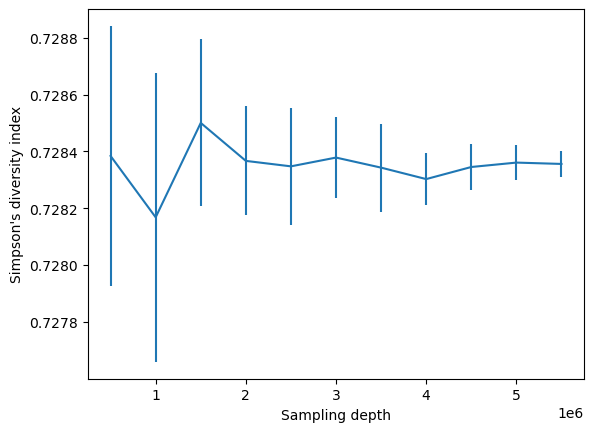

In [64]:
plt.figure()
plt.errorbar(depths, *rarefy(counts, simpson, depths, n_reps))
plt.xlabel('Sampling depth')
plt.ylabel('Simpson\'s diversity index');

In [65]:
df['simpson'] = alpha_diversity('simpson', table_sub)

## Evenness

The third category of alpha diversity metrics, [**species evenness**](https://en.wikipedia.org/wiki/Species_evenness) (or equitability) metrics, measure the closeness of taxa in a community in terms of abundance, regardless of the total number of taxa. One may consider that diversity is a combination of richness and evenness. scikit-bio implements multiple evenness metrics ([list](https://scikit.bio/docs/latest/generated/skbio.diversity.alpha.html#evenness-metrics)).

**Pielou's evenness index** (a.k.a., Shannon’s equitability index) is a widely used evenness metric. It is essentially the ratio of the actual Shannon index of the sample versus the maximum-possible Shannon index given the same number of taxa and total number of individuals. The latter is achieved when all taxa have the same abundance.

$$ J' = \frac{H'}{H'_{max}} = \frac{H'}{\log(S_{obs})} $$

Pielou's evenness index ranges between 0 (severely dominated by a few taxa) and 1 (completely even among taxa).

In [66]:
from skbio.diversity.alpha import pielou_e

In [67]:
pielou_e(counts)

np.float64(0.31105021316938625)

Rarefaction curve of Pielou's evenness index (note the scale of the *y*-axis).

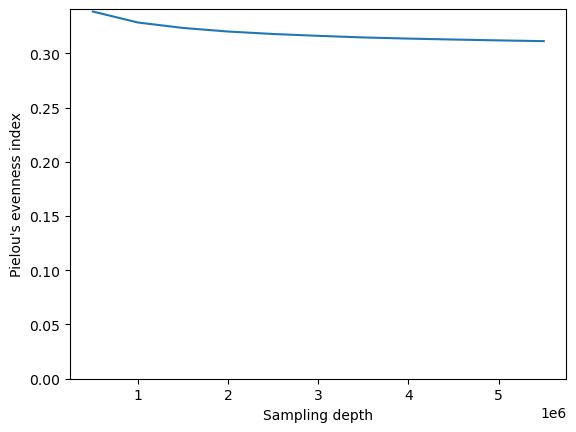

In [68]:
plt.figure()
plt.errorbar(depths, *rarefy(counts, pielou_e, depths, n_reps))
plt.ylim(bottom=0)
plt.xlabel('Sampling depth')
plt.ylabel('Pielou\'s evenness index');

In [69]:
df['pielou_e'] = alpha_diversity('pielou_e', table_sub)

## Phylogenetic diversity

There are many microbial taxa in a sample, making the contingency table high-dimensional (discussed in section 03). However, taxa are not merely a flat list of variables. They are related. Phylogenetic tree is the quantitative model measuring the evolutionary relationships among organisms. This information can be factored in in assessing the diversity of a community.

- For example, microbiome _A_ consists of 10 bacterial species spreading across the entire tree of life, whereas microbiome _B_ consists of 10 _E. coli_ strains clustered within a small clade in the phylogeny. Despite that the two communities have the same richness, one may regard _A_ as more diverse than _B_ because of the evolutionary diversity among organisms.

[**Phylogenetic diversity**](https://en.wikipedia.org/wiki/Phylogenetic_diversity) (PD) is the extension of species richness that incorporates phylogenetic information. **Faith's PD** is the most classical and widely used form of phylogenetic diversity. It is simply the sum of lengths ($l$) of branches ($b$) connecting all taxa and the root of the tree.

$$ PD = \sum l(b) $$

In [70]:
from skbio.diversity.alpha import faith_pd

To calculate phylogenetic diversity, one needs a phylogenetic tree in which tips correspond to taxa in the community. This tree is provided by `ogu.nwk` and can be parsed by scikit-bio's [`TreeNode`](https://scikit.bio/docs/latest/generated/skbio.tree.TreeNode.html) class.

In [71]:
from skbio import TreeNode

In [72]:
tree = TreeNode.read(f'{HOME}/shotgun/ogu.nwk')
tree

<TreeNode, name: N1, internal node count: 15245, tips count: 15953>

The tips are like:

In [73]:
sorted(tree.subset())[:5]

['G000005825', 'G000006175', 'G000006605', 'G000006725', 'G000006745']

The counts vector doesn't have taxon IDs. Let's extract them from the contingency table.

In [74]:
taxa = table.ids('observation')
taxa

array(['G000005825', 'G000006175', 'G000006605', ..., 'G902826605',
       'G902827015', 'G902827055'], shape=(14933,), dtype='<U10')

Now we can calculate Faith's PD.

In [75]:
faith_pd(counts, taxa, tree)

np.float64(398.99555699999996)

In [76]:
f = lambda x: faith_pd(x, taxa, tree)

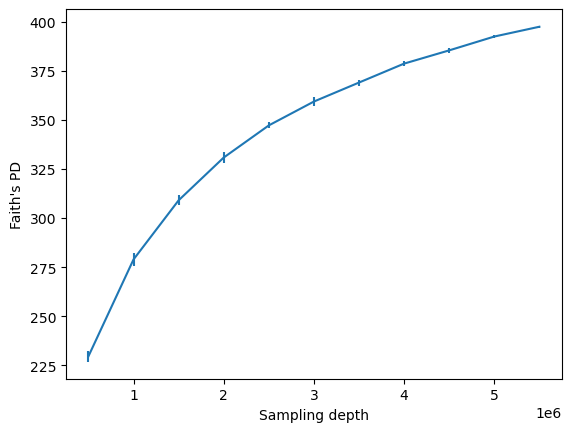

In [77]:
plt.figure()
plt.errorbar(depths, *rarefy(counts, f, depths, n_reps))
plt.xlabel('Sampling depth')
plt.ylabel('Faith\'s PD');

In [78]:
df['faith_pd'] = alpha_diversity('faith_pd', table_sub, tree=tree)

There are generalized forms of phylogenetic diversity. For example, branch lengths may be weighted by the relative abundances of descending taxa. This generalization combines richness, evenness and phylogeny in one metric. [McCoy et al. (2013)](https://peerj.com/articles/157/) further proposed **balance-weighted phylogenetic diversity** (BWPD), which lets the researcher control to what degree ($\theta$, ranges 0 - 1) branch lengths should be weighted by abundance.

$$ BWPD_{\theta} = \sum l(b)(2\min(p(b),1-p(b)))^\theta $$

scikit-bio implements a flexible function [`phydiv`](https://scikit.bio/docs/latest/generated/skbio.diversity.alpha.phydiv.html) that implements all variants of phylogenetic diversity.


In [79]:
from skbio.diversity.alpha import phydiv

By default it calculates Faith's PD (unweighted PD).

In [80]:
phydiv(counts, taxa, tree)

np.float64(398.99555699999996)

Fully-weighted PD:

In [81]:
phydiv(counts, taxa, tree, weight=True)

np.float64(0.7037949917116508)

$BWPD_{0.5}$, i.e., unrooted, half-weighted PD:

In [82]:
phydiv(counts, taxa, tree, weight=0.5, rooted=False)

np.float64(4.17188519743713)

Because it considers the relative abundances of taxa, $BWPD_{0.5}$ is also robust during rarefaction.

In [83]:
f = lambda x: phydiv(x, taxa, tree, weight=0.5, rooted=False)

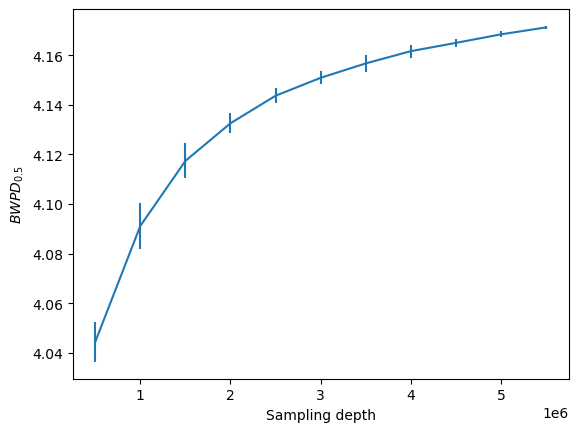

In [84]:
plt.figure()
plt.errorbar(depths, *rarefy(counts, f, depths, n_reps))
plt.xlabel('Sampling depth')
plt.ylabel('$BWPD_{0.5}$');

In [85]:
df['bwpd.5'] = alpha_diversity('phydiv', table_sub, tree=tree, weight=0.5, rooted=False)

## Comparison

It is usually a good practice to calculate different alpha diversity metrics based on a uniformly subsampled contingency table, and assess the biological patterns revealed by each of them. Note: They don't always agree with each other! Understanding each metric will help with interpretation.

In [86]:
df

,empo_1,empo_2,sobs,chao1,shannon,simpson,pielou_e,faith_pd,bwpd.5
13114.angenent.65.s001,Host-associated,Animal,972,1569.044444,2.518477,0.728300,0.366092,142.392004,3.882349
13114.angenent.65.s002,Host-associated,Animal,1072,1673.339286,2.713439,0.790132,0.388896,164.444621,4.226190
13114.angenent.65.s003,Host-associated,Animal,854,1103.000000,3.074223,0.878162,0.455445,144.250886,4.594919
13114.angenent.65.s004,Host-associated,Animal,1347,1932.634921,3.827976,0.939748,0.531248,207.225256,5.828195
13114.angenent.65.s005,Host-associated,Animal,1215,1826.110465,3.516405,0.927756,0.495094,183.998908,5.208686
...,...,...,...,...,...,...,...,...,...
13114.tucker.58.s015,Free-living,Non-saline,1153,1679.331492,3.979834,0.968841,0.564506,196.345494,4.863223
13114.tucker.58.s016,Free-living,Non-saline,847,1349.500000,2.826184,0.834675,0.419209,155.118753,4.695164
13114.zaneveld.9.s015,Host-associated,Animal,902,1350.156028,3.383282,0.948666,0.497204,149.989952,2.809366
13114.zaneveld.9.s021,Free-living,Saline,913,1468.118110,2.255039,0.683640,0.330809,148.895108,4.124211


In [87]:
metrics = ['sobs', 'chao1', 'shannon', 'simpson', 'pielou_e', 'faith_pd', 'bwpd.5']
n = len(metrics)

In [88]:
grouped = df.groupby('empo_1')
labels = ['Free', 'Host']

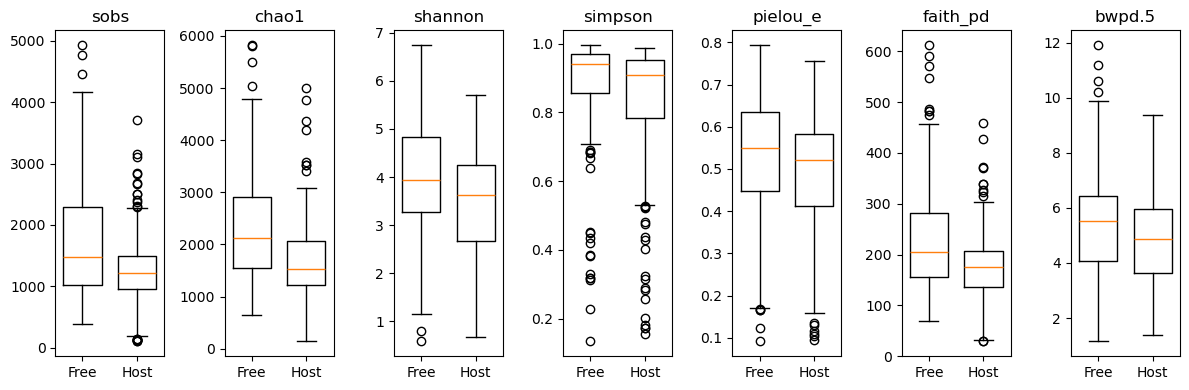

In [89]:
plt.figure(figsize=(12, 4))
for i, metric in enumerate(metrics):
    plt.subplot(1, n, i + 1)
    plt.boxplot(grouped[metric].apply(np.array), tick_labels=labels, widths=0.7)
    plt.title(metric)
plt.tight_layout()

## Summary

This section introduces alpha diversity and its application in studying microbial communities. It demonstrates how to calculate various alpha diversity metrics using scikit-bio, including richness, diversity and evenness metrics, without or with phylogeny. It also discusses sampling depth, and how subsampling can help assessing the adequacy of sampling and ensuring cross-comparability among samples.